# Les prêts de documents dans les bibliothèques de la Ville de Paris

- Olivier Viollet, olivier.viollet[a]gmail.com 
- Mars 2019

## Résumé

Cette étude recourt aux données de prêts de documents dans les bibliothèques publiques de la Ville de Paris afin de réaliser des modèles capables de prédire combien d'exemplaires d'un certain type de document seront empruntés par les usagers. Les meilleurs modèles parviennent à prédire le nombre d'exemplaires qui seront empruntés avec une erreur moyenne d'environ 10 emprunts par document ; dans 50 % des cas, l'erreur n'excède pas 2 emprunts par document. L'âge du document apparait en outre comme une variable particulièrement utile à la prédiction du nombre d'emprunts.

## Plan

1. Objectif de l'étude
2. Préparation et transformation des données
3. Construction des modèles
4. Evaluation des modèles

## 1. Objectif de l'étude

L'objectif de cette étude est de concevoir un modèle capable de prédire, dans une certaine mesure, le nombre d'exemplaires prêtés d'un document donné appartenant aux bibliothèques de la Ville de Paris à partir de ses caractéristiques. 

Un tel modèle pourrait s'avérer utile aux responsables des achats des bibliothèques publiques dès lors qu'il indiquerait approximativement combien d'exemplaires d'un document dont l'acquisition est envisagée seront empruntés sur une année. Autrement dit, un responsable pourrait utiliser le modèle afin d'estimer le nombre de fois qu'un document sera emprunté par les usagers et ajuster en conséquence la quantité d'achats de ce document.

## 2. Préparation et transformation des données

### 2.1 Importation des données

Les données ont été mises à disposition par la Ville de Paris sur son site d'ouverture des données publiques, Open Data Paris. Il s'agit des collections telles qu'elles étaient recensées au **27 juillet 2018**. Elles sont accessibles à l'adresse suivante : https://opendata.paris.fr/explore/dataset/tous-les-documents-des-bibliotheques-de-pret/information/

Le jeu de données contient initialement 815 534 observations. Seules les colonnes pouvant *a priori* s'avérer utiles à la prédiction du nombre de prêts en 2017 sont conservées. Il s'agit des variables suivantes :

- langue ;
- éditeur ; 
- date ;
- format ;
- collection ;
- numéro ;
- type de document ;
- catégorie statistique 1 ;
- catégorie statistique 2 ;
- nombre de prêts en 2017, variable cible.


Les trois lignes pour lesquelles le nombre de prêts en 2017 n'est pas connu sont retirées. 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

In [16]:
# fonction pour recoder des valeurs
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [4]:
# importer les données
titres = pd.read_csv('tous-les-documents-des-bibliotheques-de-pret.csv', 
                                      usecols = [4,7,8,9,10,12,30,33,36,37],
                                      encoding = 'utf-8', sep = ';')
print(titres.info())
titres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815534 entries, 0 to 815533
Data columns (total 10 columns):
Langue                     734510 non-null object
Editeur                    810522 non-null object
Date                       810807 non-null object
Format                     806408 non-null object
Collection                 363333 non-null object
N°                         68370 non-null object
Type de document           815532 non-null object
Nombre de prêts 2017       815531 non-null float64
Catégorie statistique 1    815531 non-null object
Catégorie statistique 2    815531 non-null object
dtypes: float64(1), object(9)
memory usage: 62.2+ MB
None


,Langue,Editeur,Date,Format,Collection,N°,Type de document,Nombre de prêts 2017,Catégorie statistique 1,Catégorie statistique 2
0,anglais,Gestalten,2013,1 vol. (395 p.) | 28 cm,NaN,NaN,Livre de Fonds spécialisés,0.0,D707 Musique,pas de code stat 2
1,anglais,Puffin,2011,"1 vol. (non paginé [32] p.) | ill. en coul., c...",NaN,NaN,Livre jeunesse,12.0,LALB Albums,pas de code stat 2
2,anglais,Kitchen 93,ca 2011,"1 vol. (407 p.) | couv. ill. en coul., ill. en...",NaN,NaN,Livre en langue étrangère,2.0,D704 Arts decoratifs,pas de code stat 2
3,français,Ed. Delatour France,2014,1 vol. (223 p.) | 21 cm,Filigrane | 2,NaN,Livre de Fonds spécialisés,0.0,D707 Musique,pas de code stat 2
4,anglais,Walker Books,2011,"[30 p.] | ill. en coul., couv. ill. en coul. |...",NaN,NaN,Livre jeunesse,7.0,LALB Albums,pas de code stat 2


Le jeu de données comporte de nombreuses valeurs manquantes dans plusieurs colonnes. De plus, la plupart des variables ne peuvent être utilisées en l'état et doivent donc faire l'objet d'un retraitement.

In [5]:
titres.isnull().sum()

Langue                      81024
Editeur                      5012
Date                         4727
Format                       9126
Collection                 452201
N°                         747164
Type de document                2
Nombre de prêts 2017            3
Catégorie statistique 1         3
Catégorie statistique 2         3
dtype: int64

In [6]:
    # retirer les valeurs manquantes dans la variable cible
titres = titres[np.isfinite(titres['Nombre de prêts 2017'])]

### 2.2 Exploration et retraitement des données

#### 2.2.1 Langue

La valeur 'nd' pour 'non disponible' est imputée aux valeurs manquantes. Le nombre de valeurs possibles pour cette variable étant important, les moins fréquentes sont fusionnées en une catégorie Autre.

Pour toutes les langues, le nombre de prêts est en général assez proche mais il convient de noter que ce sont les documents en français qui comportent le plus de valeurs très élevées.

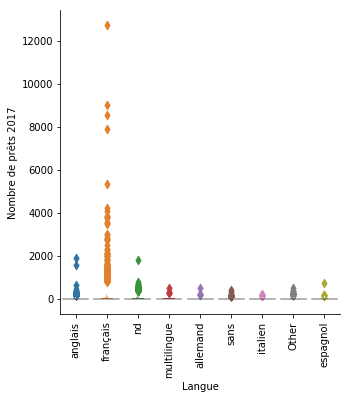

In [7]:
    # langue
#pd.value_counts(titres.Langue)
titres['Langue'].fillna('nd', inplace = True)
series = pd.value_counts(titres.Langue)
mask = (series/series.sum() * 100).lt(0.5)  # ici, niveau = 0.5 %
titres['Langue'] = np.where(titres['Langue'].isin(series[mask].index),'Other',titres['Langue'])
sns.catplot(x = 'Langue', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres).set_xticklabels(rotation=90)

#### 2.2.2 Editeur

La valeur 'nd' pour 'non disponible' est imputée aux valeurs manquantes. Le nombre de valeurs possibles pour cette variable étant important, de nouveau, les moins fréquentes sont fusionnées en une catégorie Autre. 

C'est au sein de cette dernière que l'on retrouve les valeurs les plus extrêmes, même si dans l'ensemble le niveau des prêts est assez semblable pour l'ensemble des éditeurs. 

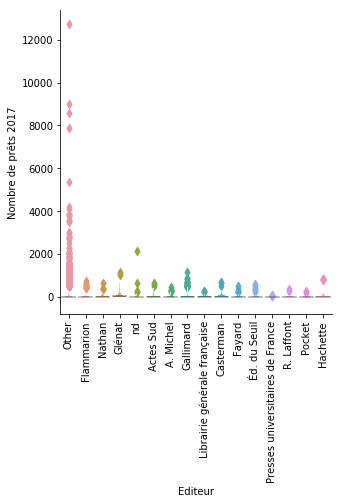

In [8]:
    # Editeur
#pd.value_counts(titres.Editeur)
titres['Editeur'].fillna('nd', inplace = True)
series = pd.value_counts(titres.Editeur)
mask = (series/series.sum() * 100).lt(0.5)  # ici, niveau = 0.5 %
titres['Editeur'] = np.where(titres['Editeur'].isin(series[mask].index),'Other',titres['Editeur'])
sns.catplot(x = 'Editeur', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres).set_xticklabels(rotation=90)

#### 2.2.3 Date

La colonne Date est impratiquable en l'état de son chargement initial car aux années sont associées, pour nombre d'observations, du texte, des symboles, etc. Elle a été retravaillée afin de ne conserver que l'année, lorsque celle-ci est disponible. **Un recodage manuel, en-dehors du code ci-dessous, a de plus été nécessaire pour environ 50 observations**. Pour nombre d'observations, seuls deux ou trois premiers chiffres sont disponibles, suivis d'un tiret ou d'un point d'interrogation, par exemple : 198-?. Pour ces observations, par prudence, la valeur a été supprimée, même si une autre stratégie aurait pu être d'imputer un chiffre a priori neutre, tel 5 : 1985, dans notre exemple. 

Il résulte de ces opérations que 50 % des documents ont une date antérieure à 2005. La médiane a été imputée sur les valeurs manquantes et sur les valeurs supprimées. A noter qu'**ont été supprimées les observations pour lesquelles la date était 2018**, dans la mesure où cette date semble refléter une erreur : comment des documents datés de 2018 ont-ils pu être empruntés en 2017 ? Quelques milliers de lignes ont ainsi été retirées du jeu de données. 

Ensuite, les années ont été soustraites à 2018, date de création du jeu de données, afin d'obtenir l'"âge" du document. L'âge de l'un d'entre eux étant probablement erroné, la médiane (13 ans) lui est substituée. 

Il existe une corrélation légèrement négative entre l'âge et le nombre de prêts en 2017.  

In [9]:
    # Date => Date_new
titres.Date = titres.Date.astype(str)
titres['Date_new'] = titres['Date'].map(lambda x: ''.join([i for i in x if i.isdigit()]))
titres['Date_new'] = titres['Date_new'].astype(str).str[:4]
titres['Date_new'] = titres['Date_new'].str.replace(' ', '')
#titres.to_csv('titres.csv', sep = ';', index = False, encoding = 'utf-8')

    ### recodage manuel d'environ 50 cellules de la colonne Date_new ###

In [17]:
titres = pd.read_csv('titres.csv',encoding = 'utf-8', sep = ';')
print('Médiane de la date : ', titres.Date_new.median()) # 2005
print(titres.Date_new.describe())
titres['Date_new'].fillna(2005, inplace = True) # impute la médiane
titres = titres[titres['Date_new'] != 2018] # retirer les lignes pour lesquelles la date d'impression est 2018

        # créer la variable âge
titres['age'] = 2018 - titres['Date_new']

        # supprimer les colonnes désormais inutiles
titres.drop(columns = ['Date','Date_new'], inplace=True)

Médiane de la date :  2005.0
count    806053.000000
mean       2002.179960
std          13.479789
min        1192.000000
25%        1996.000000
50%        2005.000000
75%        2011.000000
max        2018.000000
Name: Date_new, dtype: float64


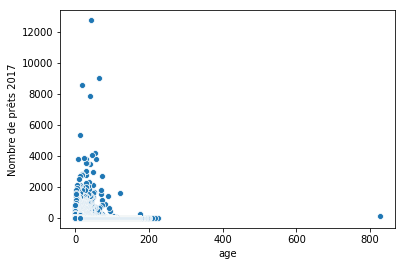

In [18]:
sns.scatterplot(x = 'age', y = 'Nombre de prêts 2017', data = titres)

In [19]:
        # une valeur semble erronnée pour l'âge : imputer la médiane à la place
titres.age.median() # 13
titres['age'] = coding(titres['age'], {826:13})

Coefficient de corrélation entre l'âge et le nombre de prêts :  [[ 1.         -0.10607475]
 [-0.10607475  1.        ]]


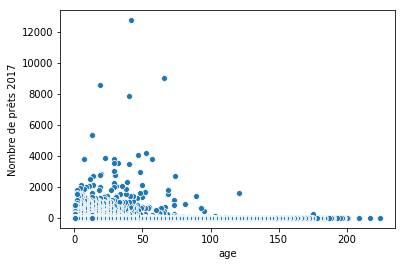

In [20]:
sns.scatterplot(x = 'age', y = 'Nombre de prêts 2017', data = titres)
print('Coefficient de corrélation entre l\'âge et le nombre de prêts : ', 
      np.corrcoef(titres['age'], titres['Nombre de prêts 2017']))

#### 2.2.4 Format

Quatre variables ont été créées à partir d'informations présentes dans la variable Format, afin de savoir, pour chacun des documents, s'il s'agit ou non d'un magazine, de DVD, de diapositives, de partitions. Le choix de ces quatre types de format a été réalisé à partir d'une observation sommaire du nombre de prêts en 2017 en fonction du format, les deux premiers (magazine et DVD) étant à première vue très représentés parmi les plus empruntés, les deux suivants parmi les moins empruntés. Les graphiques confirment cette première impression, sauf pour les DVD : seuls quelques DVD ont été fortement empruntés, et non les DVD en général par rapport aux autres formats de documents.

La colonne Format, comprenant un grand nombre de valeurs possibles, a été retravaillée afin de ne conserver que les plus fréquentes tandis que les autres ont été fusionnées dans une catégorie Autre. 

C'est au sein de cette dernière que l'on retrouve les valeurs les plus extrêmes, même si dans l'ensemble le nombre de prêts n'est pas très différent en fonction du seul format. 

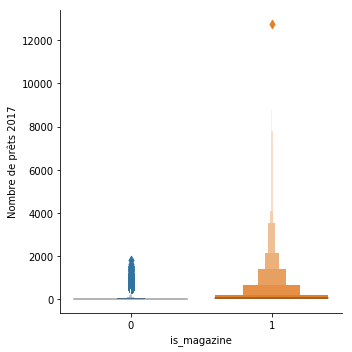

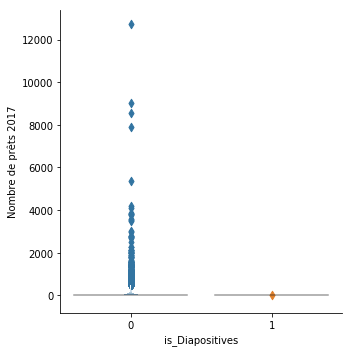

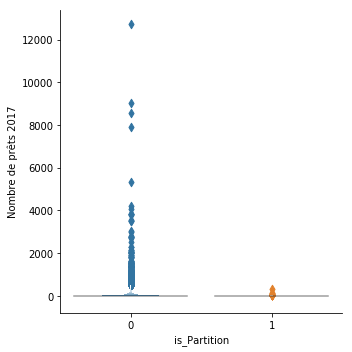

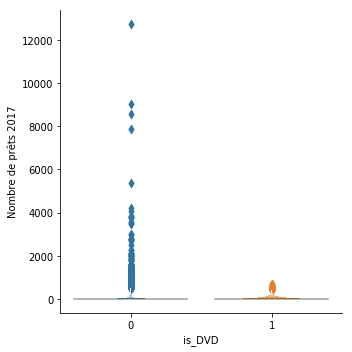

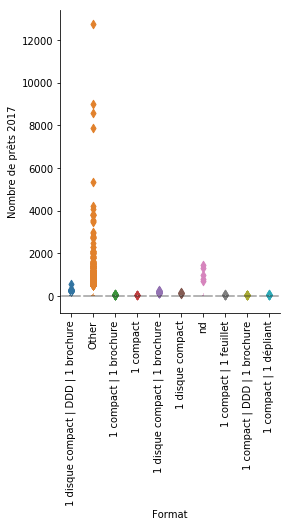

In [21]:
    # format : création de quatre variables nouvelles
#pd.value_counts(titres.Format)
titres['Format'].fillna('nd', inplace = True)

        # is Magazine
titres['is_magazine'] = titres['Format'].str.count('Magazine')
sns.catplot(x = 'is_magazine', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres) 

        # is_Diapositives
titres['is_Diapositives'] = titres['Format'].str.count('diapositives')
sns.catplot(x = 'is_Diapositives', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres)

        # is_Partition
titres['is_Partition'] = titres['Format'].str.count('partition')
titres['is_Partition'] = coding(titres['is_Partition'], {2:1})
sns.catplot(x = 'is_Partition', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres)

        # is_DVD
titres['is_DVD'] = titres['Format'].str.count('DVD')
titres['is_DVD'] = coding(titres['is_DVD'], {2:1,3:1,4:1,5:1})
sns.catplot(x = 'is_DVD', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres)

    # Format
series = pd.value_counts(titres.Format)
mask = (series/series.sum() * 100).lt(0.5)  # ici, niveau = 0.5 %
titres['Format'] = np.where(titres['Format'].isin(series[mask].index),'Other',titres['Format'])
sns.catplot(x = 'Format', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres).set_xticklabels(rotation=90) 

#### 2.2.5 Collection

La colonne Collection comprenant un trop grand nombre de niveaux et de valeurs manquantes, il a paru utile d'en extraire seulements les informations permettant de savoir si le document appartient à l'une des trois collections suivantes : Ainsi va la vie (livres - très empruntés - de Dominique de Saint Mars), Tom-Tom et Nana, Astérix. 

L'observation des données semble indiquer que ce choix est judicieux dans la mesure où les documents rattachés à chacune de ces collections sont empruntés dans les mêmes proportions, tandis que les documents d'autres collections connaissent une dispersion bien plus grande en raison de nombreuses valeurs extrêmes. 

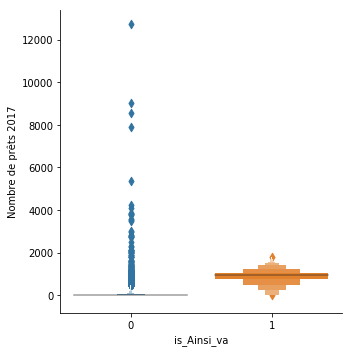

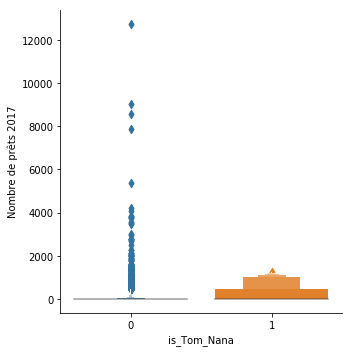

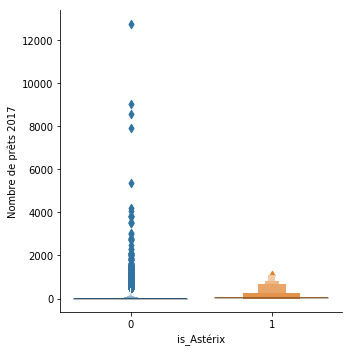

In [22]:
    # collection
#pd.value_counts(titres.Collection)
titres['Collection'].fillna('nd', inplace = True)

        # is Ainsi va la vie
titres['is_Ainsi_va'] = titres['Collection'].str.count('Ainsi va la vie')
sns.catplot(x = 'is_Ainsi_va', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres)

        # is Tom-Tom et Nana
titres['is_Tom_Nana'] = titres['Collection'].str.count('Tom-Tom et Nana')
sns.catplot(x = 'is_Tom_Nana', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres)

        # is Astérix
titres['is_Astérix'] = titres['Collection'].str.count('Astérix')
titres['is_Astérix'] = coding(titres['is_Astérix'], {2:1})
sns.catplot(x = 'is_Astérix', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres)

    # supprimer la variable d'origine
titres.drop(columns = ['Collection'], inplace=True)

#### 2.2.6 Numéro

La colonne Numéro est celle qui comporte le plus de valeurs manquantes : la valeur 'nd' pour 'non disponible' leur a été imputée. Du reste, les valeurs les moins fréquentes ont été regroupées dans une catégorie Autre.

L'observation des données laisse penser que cette variable ne sera pas utile à la prédiction des emprunts en 2017 : les valeurs disponibles présentent des dispersions similaires tandis que les valeurs imputées sont associées à des niveaux d'emprunts bien trop différents. 

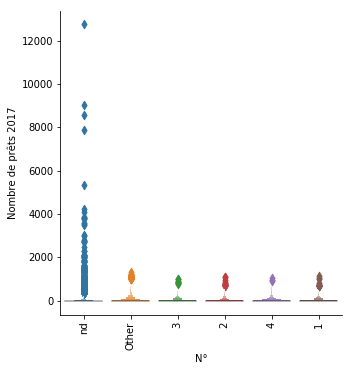

In [23]:
    # N°
#pd.value_counts(titres['N°'])
titres['N°'].fillna('nd', inplace = True)
titres['N°'] = coding(titres['N°'], {'[1]':'1', '[2]':'2', '[3]':'3'})
series = pd.value_counts(titres['N°'])
mask = (series/series.sum() * 100).lt(0.5)  # ici, niveau = 0.5 %
titres['N°'] = np.where(titres['N°'].isin(series[mask].index),'Other',titres['N°'])
sns.catplot(x = 'N°', y = 'Nombre de prêts 2017', kind = 'boxen', data = titres).set_xticklabels(rotation=90) 

#### 2.2.7 Type de document

Les types les moins fréquents ont été fusionnés au sein d'une catégorie Autre, qui contient désormais l'essentiel des valeurs extrêmes d'emprunts en 2017. Du reste, il semblerait que le nombre d'emprunts ne varie pas fortement en fonction du type.

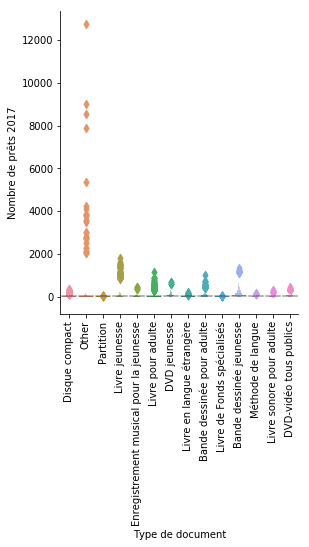

In [24]:
    # type de document
#pd.value_counts(titres['Type de document'])
series = pd.value_counts(titres['Type de document'])
mask = (series/series.sum() * 100).lt(0.5) # ici, niveau = 0.5 %
titres['Type de document'] = np.where(titres['Type de document'].isin(series[mask].index),
                                             'Other',titres['Type de document'])
sns.catplot(x = 'Type de document', y = 'Nombre de prêts 2017', 
            kind = 'boxen', data = titres).set_xticklabels(rotation=90) 

#### 2.2.8 Catégorie statistique 1

La 'catégorie statistique 1' désigne le classement des documents opéré par les bibliothèques selon leur contenu. Seuls les niveaux les plus fréquents de cette variable ont été conservés intacts tandis que les autres étaient fusionnés dans une catégorie Autre. 

Il apparait les différentes catégories statistiques connaissent globalement un niveau semblable d'emprunts de documents mais que certaines comprennent davantage de valeurs extrêmes que les autres, en particulier la catégorie Littérature française.

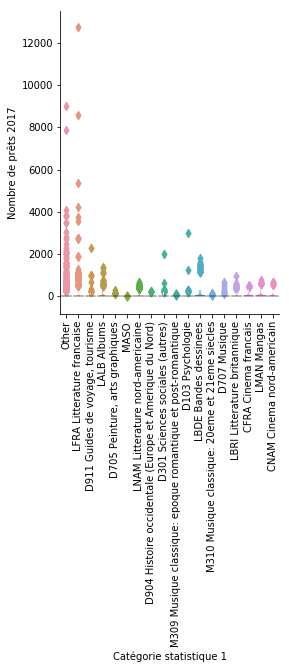

In [25]:
    # cat stat 1
#pd.value_counts(titres['Catégorie statistique 1'])
series = pd.value_counts(titres['Catégorie statistique 1'])
mask = (series/series.sum() * 100).lt(1) # ici, niveau = 1 %
titres['Catégorie statistique 1'] = np.where(titres['Catégorie statistique 1'].isin(series[mask].index),
                                             'Other',titres['Catégorie statistique 1'])
titres['Catégorie statistique 1'] = coding(titres['Catégorie statistique 1'], 
                                           {'65':'cat65', '136':'cat136','155':'cat155','95':'cat95'})
sns.catplot(x = 'Catégorie statistique 1', y = 'Nombre de prêts 2017', 
            kind = 'boxen', data = titres).set_xticklabels(rotation=90) 

#### 2.2.9 Catégorie statistique 2

Pour certains documents, un deuxième niveau de classification a été appliqué par les bibliothèques. Les niveaux les moins fréquents ont été fusionnés dans une catégorie Autre.

L'observation des données laisse penser que cette variable ne sera pas utile pour prédire le nombre de prêts en 2017.

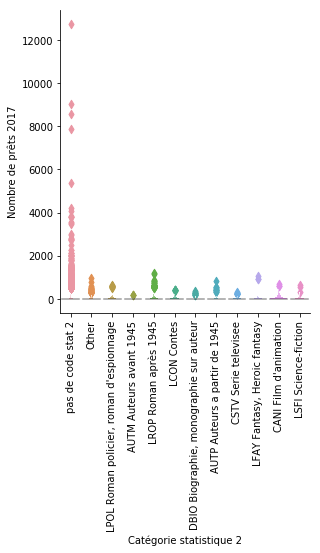

In [26]:
    # cat stat 2
#pd.value_counts(titres['Catégorie statistique 2'])
series = pd.value_counts(titres['Catégorie statistique 2'])
mask = (series/series.sum() * 100).lt(0.5)  # ici, niveau = 0.5 % 
titres['Catégorie statistique 2'] = np.where(titres['Catégorie statistique 2'].isin(series[mask].index),
                                             'Other',titres['Catégorie statistique 2'])
sns.catplot(x = 'Catégorie statistique 2', y = 'Nombre de prêts 2017', 
            kind = 'boxen', data = titres).set_xticklabels(rotation=90) 

In [27]:
titres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806944 entries, 0 to 815530
Data columns (total 16 columns):
Langue                     806944 non-null object
Editeur                    806944 non-null object
Format                     806944 non-null object
N°                         806944 non-null object
Type de document           806944 non-null object
Nombre de prêts 2017       806944 non-null float64
Catégorie statistique 1    806944 non-null object
Catégorie statistique 2    806944 non-null object
age                        806944 non-null float64
is_magazine                806944 non-null int64
is_Diapositives            806944 non-null int64
is_Partition               806944 non-null int64
is_DVD                     806944 non-null int64
is_Ainsi_va                806944 non-null int64
is_Tom_Nana                806944 non-null int64
is_Astérix                 806944 non-null int64
dtypes: float64(2), int64(7), object(7)
memory usage: 124.7+ MB


## 3. Construction des modèles

Le jeu de données principal est coupé en plusieurs morceaux. Dans un premier temps, sont distingués un jeu d'entrainement et un jeu de test. Dans un second temps, le jeu d'entrainement est lui-même coupé en un jeu d'entrainement et un jeu de validation. Les modèles sont entrainés sur ce dernier jeu d'entrainement, puis évalués et ajustés sur le jeu de validation. 

La variable cible est le nombre de prêts en 2017 pour chacun des 806 944 documents. En moyenne, les documents ont été prêtés 11 fois chacun en 2017. Cette moyenne est cependant trompeuse car :
- une importante minorité de documents n'a été prêté aucune fois en 2017 ;
- plus de la moitié des documents ont été empruntés moins de 2 fois en 2017 ;
- plus de trois quarts des documents ont été prêtés moins de 8 fois en 2017 ;
- quelques documents ont été empruntés un très grand nombre de fois, jusqu'à 12 744.

En raison de la grande dispersion des données de prêts, que reflète au demeurant un écart-type de 47, il apparait utile de mesurer la performance des modèles avec l'**erreur médiane absolue** en plus de l'**erreur moyenne absolue** car cette dernière est davantage affectée par la présence de données extrêmes. Autrement dit, l'erreur médiane parait ici mieux à même de synthétiser la marge d'erreur avec laquelle le modèle prédit le nombre de prêts d'un document donné.

count    806944.000000
mean         11.376845
std          47.535018
min           0.000000
25%           0.000000
50%           2.000000
75%           8.000000
max       12744.000000
Name: Nombre de prêts 2017, dtype: float64
La médiane de la variable cible est :  2.0


C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


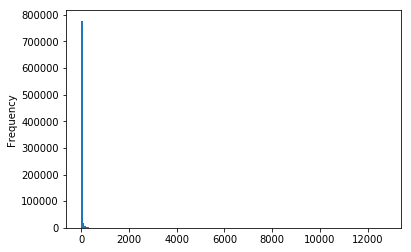

In [28]:
# préparer les jeux d'entrainement et de test
Target = titres['Nombre de prêts 2017']
print(Target.describe())
print('La médiane de la variable cible est : ', Target.median()) # 2
Target.plot.hist(bins = 200)

titres.drop(columns = ['Nombre de prêts 2017'], inplace=True)

# créer les variables binaires
predictors = pd.get_dummies(titres)

# créer les jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

# créer les jeux d'entrainement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# normaliser la variable numérique âge
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_preprocess = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_preprocess, columns = X_train.columns)
del X_train_preprocess
X_val_preprocess = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_preprocess, columns = X_val.columns)
del X_val_preprocess

del titres

### 3.1 Régression linéaire

Le premier modèle réalisé est une simple régression linéaire. Son erreur moyenne s'élève à 13 tandis que son erreur médiane est comprise entre 5 et 6. Ceci signifie que si, par exemple, pour un document donné, le modèle prédit qu'il sera emprunté 20 fois, alors on peut s'attendre à ce qu'il soit réellement emprunté entre 7 et 33 fois. Il peut l'être davantage que 33 fois, ou moins que 7, mais alors l'erreur sera moindre sur un autre document. 

Toutefois, l'écart entre l'erreur moyenne et l'erreur médiane confirme que la présence de valeurs extrêmes dans la variable à prédire - le nombre de prêts en 2017 - rend utile le recours à l'erreur médiane comme mesure de performance. En l'occurrence, elle indique ici que dans 50 % des prédictions d'emprunts, le modèle prédit à moins de 6 emprunts près le nombre réel d'emprunts ; autrement dit, dans 50 % des cas, le modèle se trompe de moins de 6 prêts.

In [29]:
# régression linéaire
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 13.1
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train, y_train_pred)) # 5.8

y_val_pred = reg.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred)
y_val_pred.describe()
y_val_pred.rename(columns = {0:'predictions'}, inplace = True)
y_val_pred.loc[y_val_pred['predictions'] < 0, 'predictions'] = 0
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, y_val_pred)) # 12.7
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, y_val_pred)) # 5.5

Erreur moyenne sur le jeu d'entrainement :  13.100338444245649
Erreur médiane sur le jeu d'entrainement :  5.8125
Erreur moyenne sur le jeu de validation :  12.697070132482903
Erreur médiane sur le jeu de validation :  5.546875


A noter que ce modèle linéaire explique moins de 20 % de la variance du nombre de prêts en 2017 (R² = 16.9 %).

In [30]:
import statsmodels.api as sm
model = sm.OLS(y_train.values, X_train.values)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1221.
Date:                Sun, 31 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:33:02   Log-Likelihood:            -2.6961e+06
No. Observations:              516444   AIC:                         5.392e+06
Df Residuals:                  516357   BIC:                         5.393e+06
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -55.6750      1.123    -49.556      0.0

Il est possible qu'un modèle non-linéaire soit mieux à même de prédire le nombre de prêts. Pour cela, en restant dans le cadre d'une régression linéaire, il convient de transformer la variable cible - nombre de prêts - et/ou les variables explicatives. En l'occurrence, nous choisissons de transformer la variable cible en prenant son logarithme naturel, d'entrainer le modèle puis, afin d'obtenir des prédictions dans l'unité de départ, de transformer ces prédictions avec la fonction exponentielle. Il apparait alors que l'**erreur moyenne par document baisse à 10 prêts** (contre 13), que **dans plus de 50 % des cas l'erreur est de moins de 2 prêts par document**, et que dans trois cas sur quatre, l'erreur est de moins de 5,7 prêts par document. 

In [31]:
    # logarithme naturel
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 10.2
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train, np.exp(y_train_pred))) # 1.8

y_val_pred = reg_log.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, np.exp(y_val_pred))) # 10.1
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, np.exp(y_val_pred))) # 1.8

Erreur moyenne sur le jeu d'entrainement :  10.218268644922189
Erreur médiane sur le jeu d'entrainement :  1.828535960352658
Erreur moyenne sur le jeu de validation :  10.06901314044317
Erreur médiane sur le jeu de validation :  1.8029635699281998


In [32]:
error = y_val - np.exp(y_val_pred)
error = np.abs(error)
print(error.describe())

count    129111.000000
mean         10.069013
std          44.750583
min           0.000000
25%           0.738795
50%           1.802964
75%           5.693204
max        9006.577166
Name: Nombre de prêts 2017, dtype: float64


### 3.2 Gradient boosting machine

La deuxième famille de modèle à laquelle nous recourons ici est celle du *boosting*, technique ensembliste à base de modèles plus faibles. Nous utilisons sa version dite *light* notamment en raison de sa vitesse de calcul. Sans transformation de la variable cible - nombre de prêts - le modèle prédit en moyenne à environ 11-12 emprunts près le nombre d'emprunts dans l'année mais à moins de 4 emprunts près dans 50 % des cas. 

Comme pour la régression linéaire, les résultats sont **meilleurs en prenant le logarithme naturel** de la variable cible, avec une **erreur moyenne** inférieure à 10, une **erreur médiane** inférieure à 2 ; dans trois cas sur quatre, l'erreur est de moins de 5,7 prêts par document.

In [33]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

d_train = lgb.Dataset(X_train, label = y_train["Nombre de prêts 2017"])

In [34]:
clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 11.8
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train, y_train_pred)) # 4.1

y_val_pred = clf.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred)
y_val_pred.describe()
y_val_pred.rename(columns = {0:'predictions'}, inplace = True)
y_val_pred.loc[y_val_pred['predictions'] < 0, 'predictions'] = 0
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, y_val_pred)) # 11.7
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, y_val_pred)) # 4.1


Erreur moyenne sur le jeu d'entrainement :  11.770087993900356
Erreur médiane sur le jeu d'entrainement :  4.149933179236179
Erreur moyenne sur le jeu de validation :  11.670672312067913
Erreur médiane sur le jeu de validation :  4.140584382752647


Erreur moyenne sur le jeu d'entrainement :  9.926337411853593
Erreur médiane sur le jeu d'entrainement :  1.7393572648680484
Erreur moyenne sur le jeu de validation :  9.778418707684395
Erreur médiane sur le jeu de validation :  1.7240816234036098


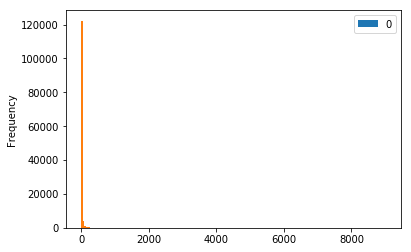

In [35]:
    # logarithme naturel
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
d_train = lgb.Dataset(X_train, label = y_train_log["Nombre de prêts 2017"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 9.9
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train, np.exp(y_train_pred))) # 1.7

y_val_pred = clf.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, np.exp(y_val_pred))) # 9.8
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, np.exp(y_val_pred))) # 1.7
pd.DataFrame(np.exp(y_val_pred)).describe()
y_val.describe()

pd.DataFrame(np.exp(y_val_pred)).plot.hist(bins = 200)
y_val.plot.hist(bins = 200)

In [36]:
error = y_val - np.exp(y_val_pred)
error = np.abs(error)
print(error.describe())

count    129111.000000
mean          9.778419
std          44.173870
min           0.000021
25%           0.653899
50%           1.724082
75%           5.695793
max        8960.356650
Name: Nombre de prêts 2017, dtype: float64


### 3.3 Forêt aléatoire

La forêt aléatoire est également une technique ensembliste, à la base d'arbres de décision. En gardant la valeur brute du nombre de prêts en 2017, le modèle prédit en moyenne à 10 emprunts près mais dans 50 % des cas son erreur est inférieure à 2 emprunts. Les résultats sont presque identiques en prenant le logarithme naturel du nombre de prêts en 2017. A noter que pour éviter un temps de calcul trop long, seuls 5 % des données d'entrainement ont été utilisées pour former la forêt. 

In [37]:
# forêt aléatoire
X_train, X_train_sample, y_train, y_train_sample = train_test_split(X_train, y_train, test_size=0.05, random_state=80)
forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1, max_depth = 10)
forest.fit(X_train_sample, y_train_sample)
y_train_pred = forest.predict(X_train_sample)
y_val_pred = forest.predict(X_val)

print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train_sample, y_train_pred)) #9.3
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train_sample, y_train_pred)) # 2

print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, y_val_pred)) #10.3
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, y_val_pred)) # 2


C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Erreur moyenne sur le jeu d'entrainement :  9.326482205785538
Erreur médiane sur le jeu d'entrainement :  2.0
Erreur moyenne sur le jeu de validation :  10.297332140561222
Erreur médiane sur le jeu de validation :  2.0


In [38]:
    # logarithme naturel
y_train_log = y_train_sample + 0.1 
y_train_log = np.log(y_train_log)

forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1, max_depth = 10)
forest.fit(X_train_sample, y_train_log)

y_train_pred = forest.predict(X_train_sample)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train_sample, np.exp(y_train_pred))) # 9.7
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train_sample, np.exp(y_train_pred))) # 2

y_val_pred = forest.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, np.exp(y_val_pred))) # 10.0
print('Erreur médiane sur le jeu de validation : ', median_absolute_error(y_val, np.exp(y_val_pred))) # 2.1

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Erreur moyenne sur le jeu d'entrainement :  9.717932683797871
Erreur médiane sur le jeu d'entrainement :  1.968505505577824
Erreur moyenne sur le jeu de validation :  10.015568981187524
Erreur médiane sur le jeu de validation :  2.0767832477536983


## 4. Evaluation des modèles

Les modèles ont été entrainés et leurs hyperparamètres ajustés sur un jeu de données dit d'entrainement, comprenant en son sein un jeu de validation. Désormais, il convient de recréer les jeux de données d'entrainement et de test, d'entrainer une dernière fois les modèles sur le jeu d'entrainement complet, c'est-à-dire intégrant le jeu qui avait été utilisé pour la validation, et d'évaluer leurs performances sur le jeu de test. Les performances devraient être semblables à celles obtenues sur le jeu de validation.

In [46]:
# re-créer les jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

# normaliser la variable numérique âge
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train_preprocess = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_preprocess, columns = X_train.columns)
del X_train_preprocess

X_test_preprocess = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_preprocess, columns = X_test.columns)
del X_test_preprocess

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### 4.1 Régression linéaire avec logarithme naturel

En prenant le logarithme naturel du nombre de prêts, le modèle commet en moyenne 10 erreurs par document mais dans plus de 50 % des cas son erreur est de moins de 2 prêts par document. 

In [40]:
    # régression linéaire avec le logarithme naturel
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 10.2
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train, np.exp(y_train_pred))) # 1.8

y_test_pred = reg_log.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test, np.exp(y_test_pred))) # 10.1
print('Erreur médiane sur le jeu de test : ', median_absolute_error(y_test, np.exp(y_test_pred))) # 1.8

Erreur moyenne sur le jeu d'entrainement :  10.191600315263804
Erreur médiane sur le jeu d'entrainement :  1.8245852150751276
Erreur moyenne sur le jeu de test :  10.129894665764631
Erreur médiane sur le jeu de test :  1.8224284200731486


### 4.2 Light GBM

En prenant le logarithme naturel du nombre de prêts, le modèle commet en moyenne 10 erreurs par document. Dans plus de 50 % des cas, son erreur est de moins de 2 prêts par document, et est inférieure à 6 prêts dans trois cas sur quatre. Ces résultats sont donc très proches de ceux obtenus par la régression linéaire. 

In [47]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

    # logarithme naturel
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
d_train = lgb.Dataset(X_train, label = y_train_log["Nombre de prêts 2017"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 9.9
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train, np.exp(y_train_pred))) # 1.7

y_test_pred = clf.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test, np.exp(y_test_pred))) # 9.9
print('Erreur médiane sur le jeu de test : ', median_absolute_error(y_test, np.exp(y_test_pred))) # 1.7

Erreur moyenne sur le jeu d'entrainement :  9.914353721648201
Erreur médiane sur le jeu d'entrainement :  1.7446861437962358
Erreur moyenne sur le jeu de test :  9.86735009828151
Erreur médiane sur le jeu de test :  1.7468177162706384


In [48]:
error = y_test - np.exp(y_test_pred)
error = np.abs(error)
error.describe()

count    161389.000000
mean          9.867350
std          38.871157
min           0.000130
25%           0.669685
50%           1.746818
75%           5.765812
max        4160.049880
Name: Nombre de prêts 2017, dtype: float64

Il est par ailleurs intéressant d'observer quelles sont les variables qui ont le plus aidé l'algorithme à réaliser ses prédictions. En l'occurrence, il s'agit de très loin de la variable 'âge' que nous avions créée à partir de la colonne 'Date' du jeu de données initial, devant le fait pour le document d'être en langue française. A noter que l'importance d'une variable ne signifie pas qu'une valeur plus élevée pour celle-ci soit associée à un plus grand nombre de prêts.

In [42]:
# importance des variables
pd.DataFrame(sorted(zip(clf.feature_importance(),X_test.columns)), columns=['Value','Feature']).sort_values('Value', ascending=False)

,Value,Feature
92,407,age
91,169,Langue_français
90,85,Type de document_Other
89,81,is_DVD
88,81,Type de document_Livre pour adulte
87,81,Type de document_Livre jeunesse
86,73,Catégorie statistique 2_pas de code stat 2
85,61,Catégorie statistique 1_Other
83,54,Catégorie statistique 1_LALB Albums
84,54,Langue_nd


### 4.3 Forêt aléatoire

En gardant la valeur brute du nombre de prêts, et non son logarithme, le modèle commet en moyenne 10 erreurs par document. Dans plus de 50 % des cas, son erreur est de moins de 2 prêts par document, et dans trois cas sur quatre, elle est inférieure à 6 prêts. Ces résultats sont donc très proches de ceux obtenus par les autres modèles. 

In [43]:
# forêt aléatoire
X_train, X_train_sample, y_train, y_train_sample = train_test_split(X_train, y_train, test_size=0.05, random_state=80)
forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1, max_depth = 10)
forest.fit(X_train_sample, y_train_sample)
y_train_pred = forest.predict(X_train_sample)
y_test_pred = forest.predict(X_test)

print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train_sample, y_train_pred)) # 9.5
print("Erreur médiane sur le jeu d\'entrainement : ", median_absolute_error(y_train_sample, y_train_pred)) # 2.0

print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test, y_test_pred)) # 10.1
print('Erreur médiane sur le jeu de test : ', median_absolute_error(y_test, y_test_pred)) # 2.1

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Erreur moyenne sur le jeu d'entrainement :  9.490211599231676
Erreur médiane sur le jeu d'entrainement :  2.0
Erreur moyenne sur le jeu de test :  10.149517934927411
Erreur médiane sur le jeu de test :  2.0999999999999996


In [45]:
error = y_test - y_test_pred
error = np.abs(error)
error.describe()

count    161389.000000
mean         10.149518
std          37.100997
min           0.000000
25%           1.000000
50%           2.100000
75%           6.000000
max        3925.500000
Name: Nombre de prêts 2017, dtype: float64

De nouveau, l'âge du document est de très loin la variable ayant le plus aidé la forêt aléatoire à réaliser ses prédictions, ce qui ne signifie pas, là encore, qu'un âge plus élevé soit associé à davantage d'emprunts.

In [44]:
    # importance des variables
pd.DataFrame({'Variable':pd.DataFrame(X_test).columns,'Importance':forest.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
0,age,3.484971e-01
5,is_Ainsi_va,1.436951e-01
49,Type de document_Bande dessinée jeunesse,5.405512e-02
12,Langue_français,2.715894e-02
4,is_DVD,2.543832e-02
50,Type de document_Bande dessinée pour adulte,2.468966e-02
57,Type de document_Livre jeunesse,2.051129e-02
79,Catégorie statistique 1_MASO,1.932972e-02
43,N°_1,1.887775e-02
63,Catégorie statistique 1_CFRA Cinema francais,1.655684e-02
